# Lesson 3: Expand Data Agent Capabilities

You can use [Cortex agents](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-agents) to retrieve data across unstructured and structured systems. In this example, the agent will answer questions from structured CRM data and unstructured meeting notes. This addition will empower your multi-agent system to be able to answer deeper questions requiring reasoning across many different data sources.

## 3.1 Load the environment

The environment variables include the OpenAI API and Tavily API keys, and the Snowflake credentials required to access the Snowflake account created for this course. The environment variables also define the name of the database where the provided data is stored.

In [1]:
from dotenv import load_dotenv
_ = load_dotenv(override=True)

**Notes**: 

- These variables are already defined in this environment. If you'd like to run the notebook locally, you can define them in a `.env` file. For an env template, you can check the file `env.template` in this lesson's folder.
- To learn more about how the data was set up for this course, you can check this [guide](https://quickstarts.snowflake.com/guide/getting_started_with_cortex_agents/index.html#0).

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>To access <code>requirements.txt</code>, <code>env.template</code>, <code>prompts.py</code>, and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

</div>

## 3.2 Explore the data

The structured data (accessed via [Cortex Analyst](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-analyst)) is Customer Relationship Management (CRM) data, containing recent deals with values, company names, deal status, product lines, and more.

The unstructured data (accessed via [Cortex Search](https://docs.snowflake.com/user-guide/snowflake-cortex/cortex-search/cortex-search-overview)) contains notes from meetings with these prospective customers.

By using both the structured and unstructured data, you can ask analytical questions about recent deal values, uncover themes from the notes, or even combine the information to go even deeper.

When combined with public data, you can uncover deep, actionable insights from your data!

### Structured data: CRM/deal data

In [2]:
from helper import snowpark_session

In [3]:
import pandas as pd

snowpark_session.sql("USE WAREHOUSE SALES_INTELLIGENCE_WH").collect()
pd.DataFrame(snowpark_session.sql("select * from sales_intelligence.data.sales_metrics limit 5").collect())

,DEAL_ID,CUSTOMER_NAME,DEAL_VALUE,CLOSE_DATE,SALES_STAGE,WIN_STATUS,SALES_REP,PRODUCT_LINE
0,DEAL001,TechCorp Inc,75000.0,2024-02-15,Closed,True,Sarah Johnson,Enterprise Suite
1,DEAL002,SmallBiz Solutions,25000.0,2024-02-01,Lost,False,Mike Chen,Basic Package
2,DEAL003,SecureBank Ltd,150000.0,2024-01-30,Closed,True,Rachel Torres,Premium Security
3,DEAL004,GrowthStart Up,100000.0,2024-02-10,Pending,False,Sarah Johnson,Enterprise Suite
4,DEAL005,DataDriven Co,85000.0,2024-02-05,Closed,True,James Wilson,Analytics Pro


### Unstructured data: meeting notes

In [4]:
import textwrap

rows = snowpark_session.sql("""
    select transcript_text
    from sales_intelligence.data.sales_conversations
    limit 1
""").collect()

if not rows:
    print("No transcripts found.")
else:
    try:
        transcript = rows[0]['TRANSCRIPT_TEXT']  # Snowflake usually uppercases column names
    except Exception:
        transcript = rows[0][0]

    cleaned = " ".join(transcript.split())  # collapse excessive whitespace/newlines
    wrapped = textwrap.fill(cleaned, width=100)

    print("=== Meeting Notes ===\n")
    print(wrapped)
    print("\n=== End ===")

=== Meeting Notes ===

Initial discovery call with TechCorp Inc's IT Director and Solutions Architect. Client showed strong
interest in our enterprise solution features, particularly the automated workflow capabilities. The
main discussion centered around integration timeline and complexity. They currently use Legacy
System X for their core operations and expressed concerns about potential disruption during
migration. The team asked detailed questions about API compatibility and data migration tools.
Action items include providing a detailed integration timeline document, scheduling a technical
deep-dive with their infrastructure team, and sharing case studies of similar Legacy System X
migrations. The client mentioned a Q2 budget allocation for digital transformation initiatives.
Overall, it was a positive engagement with clear next steps.

=== End ===


## 3.3 Initialize Cortex Agent 

This agent will retrieve sales-related data from Snowflake using both Text2SQL (done by Cortex Analyst) and Semantic Search (done by Cortex Search).

In [5]:
from snowflake.snowpark import Session
from snowflake.core import Root
from pydantic import BaseModel, PrivateAttr
from snowflake.core.cortex.lite_agent_service import AgentRunRequest
from typing import Any, Type
from langchain.schema import HumanMessage
from langgraph.graph import END
from langgraph.types import Command
from typing import Literal, Dict
import json

from helper import State

- The Cortex Analyst uses a semantic model to perform text-to-SQL conversion. You can learn more about semantic models [here](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-analyst/semantic-model-spec). 
- To be able to perform semantic search across your unstructured data stored in Snowflake, you can create a [Cortex Search service](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-search/cortex-search-overview#create-the-service).

To learn more about how the semantic model and the search service were created, you can check this [guide](https://quickstarts.snowflake.com/guide/getting_started_with_cortex_agents/index.html#0).

In [6]:
SEMANTIC_MODEL_FILE = "@sales_intelligence.data.models/sales_metrics_model.yaml"

CORTEX_SEARCH_SERVICE = "sales_intelligence.data.sales_conversation_search"

In [7]:
# ---- Agent Setup ----
class CortexAgentArgs(BaseModel):
    query: str

In [8]:
class CortexAgentTool:
    name: str = "CortexAgent"
    description: str = "answers questions using sales conversations and metrics"
    args_schema: Type[CortexAgentArgs] = CortexAgentArgs

    _session: Session = PrivateAttr()
    _root: Root = PrivateAttr()
    _agent_service: Any = PrivateAttr()

    def __init__(self, session: Session):
        self._session = session
        self._root = Root(session)
        self._agent_service = self._root.cortex_agent_service

    def _build_request(self, query: str) -> AgentRunRequest:
        return AgentRunRequest.from_dict({
            "model": "claude-3-5-sonnet",
            "tools": [
                {"tool_spec": {"type": "cortex_analyst_text_to_sql", "name": "analyst1"}},
                {"tool_spec": {"type": "cortex_search", "name": "search1"}},
            ],
            "tool_resources": {
                "analyst1": {"semantic_model_file": SEMANTIC_MODEL_FILE},
                "search1": {
                    "name": CORTEX_SEARCH_SERVICE,
                    "max_results": 10,
                    "id_column": "conversation_id"
                }
            },
            "messages": [
                {"role": "user", "content": [{"type": "text", "text": query}]}
            ]
        })

    def _consume_stream(self, stream):
        text, sql, citations = "", "", []
        for evt in stream.events():
            try:
                delta = (evt.data.get("delta") if isinstance(evt.data, dict)
                         else json.loads(evt.data).get("delta")
                         or json.loads(evt.data).get("data", {}).get("delta"))
            except Exception:
                continue

            if not isinstance(delta, dict):
                continue

            for item in delta.get("content", []):
                if item.get("type") == "text":
                    text += item.get("text", "")
                elif item.get("type") == "tool_results":
                    for result in item["tool_results"].get("content", []):
                        if result.get("type") != "json":
                            continue
                        j = result["json"]
                        text += j.get("text", "")
                        sql = j.get("sql", sql)
                        citations.extend({
                            "source_id": s.get("source_id"),
                            "doc_id": s.get("doc_id")
                        } for s in j.get("searchResults", []))
        return text, sql, str(citations)

    def run(self, query: str, **kwargs):
        """
        This agent will retrieve sales-related data from Snowflake using both Text2SQL and Semantic Search.
        """
        req = self._build_request(query)
        stream = self._agent_service.run(req)
        text, sql, citations = self._consume_stream(stream)

        results_str = ""
        if sql:
            try:
                # Ensure warehouse is set explicitly before running the SQL
                self._session.sql("USE WAREHOUSE SALES_INTELLIGENCE_WH").collect()

                df = self._session.sql(sql.rstrip(";")).to_pandas()
                results_str = df.to_string(index=False)
            except Exception as e:
                results_str = f"SQL execution error: {e}"

        return text, citations, sql, results_str

In [9]:
cortex_agent_tool = CortexAgentTool(session=snowpark_session)

In [10]:
from langgraph.prebuilt import create_react_agent
from helper import agent_system_prompt
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

cortex_agent = create_react_agent(
    llm,
    tools=[cortex_agent_tool.run],
    prompt=agent_system_prompt(f"""
        You are the Researcher. You can answer questions 
        using customer deal data along with meeting notes.
        Do not take any further action.
    """))

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> The following two queries might take a few minutes to output the results.</p>

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
    <p>🚨 &nbsp; <b>Different Run Results:</b> If the agent does not return the top 3 client deals and mentions it can't access the structured data, it could be because it did not choose the Cortex Analyst tool (which gives it access to the structured data containing client deals) and chose the Cortex Search tool instead (which gives it access to the meeting notes). You do not need to re-run the queries.
</div>

In [11]:
agent_response = cortex_agent.invoke(
    {"messages":"what are our top 3 customer deals?"})

print(agent_response['messages'][-1].content)

FINAL ANSWER: The top 3 customer deals based on total deal value are:

1. FastTrack Ltd with a deal value of $180,000.
2. SecureBank Ltd with a deal value of $150,000.
3. HealthTech Solutions with a deal value of $120,000.


In [12]:
agent_response = cortex_agent.invoke(
    {"messages":"what is the next step in the sales process for healthtech"})

print(agent_response['messages'][-1].content)

Based on the available data, the next step in the sales process for HealthTech appears to be the technical evaluation or deep dive phase. This involves a detailed examination of API infrastructure, data security protocols, and compliance requirements, especially focusing on HIPAA compliance, data encryption standards, and API rate limiting. A follow-up session with the compliance team is also indicated, suggesting the process is currently in the technical validation and compliance review phase.


Let's now wrap a LangGraph node around the react agent.

In [13]:
def cortex_agents_research_node(
    state: State,
) -> Command[Literal["executor"]]:
    query = state.get("agent_query", state.get("user_query", ""))
    # Call the tool with the string query
    agent_response = cortex_agent.invoke({"messages":query})
    # Compose a message content string with all results new HumanMessage with the result
    new_message = HumanMessage(content=agent_response['messages'][-1].content, name="cortex_researcher")
    # Append to the message history
    goto = "executor"
    return Command(
        update={"messages": [new_message]},
        goto=goto,
    )

## 3.4 Build the agent graph

In [14]:
from helper import State, planner_node, executor_node, web_research_node, chart_node, chart_summary_node, synthesizer_node

from langgraph.graph import START, StateGraph

workflow = StateGraph(State)
workflow.add_node("planner", planner_node)
workflow.add_node("executor", executor_node)
workflow.add_node("web_researcher", web_research_node)
workflow.add_node("cortex_researcher", cortex_agents_research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("chart_summarizer", chart_summary_node)
workflow.add_node("synthesizer", synthesizer_node)

workflow.add_edge(START, "planner")

graph = workflow.compile()

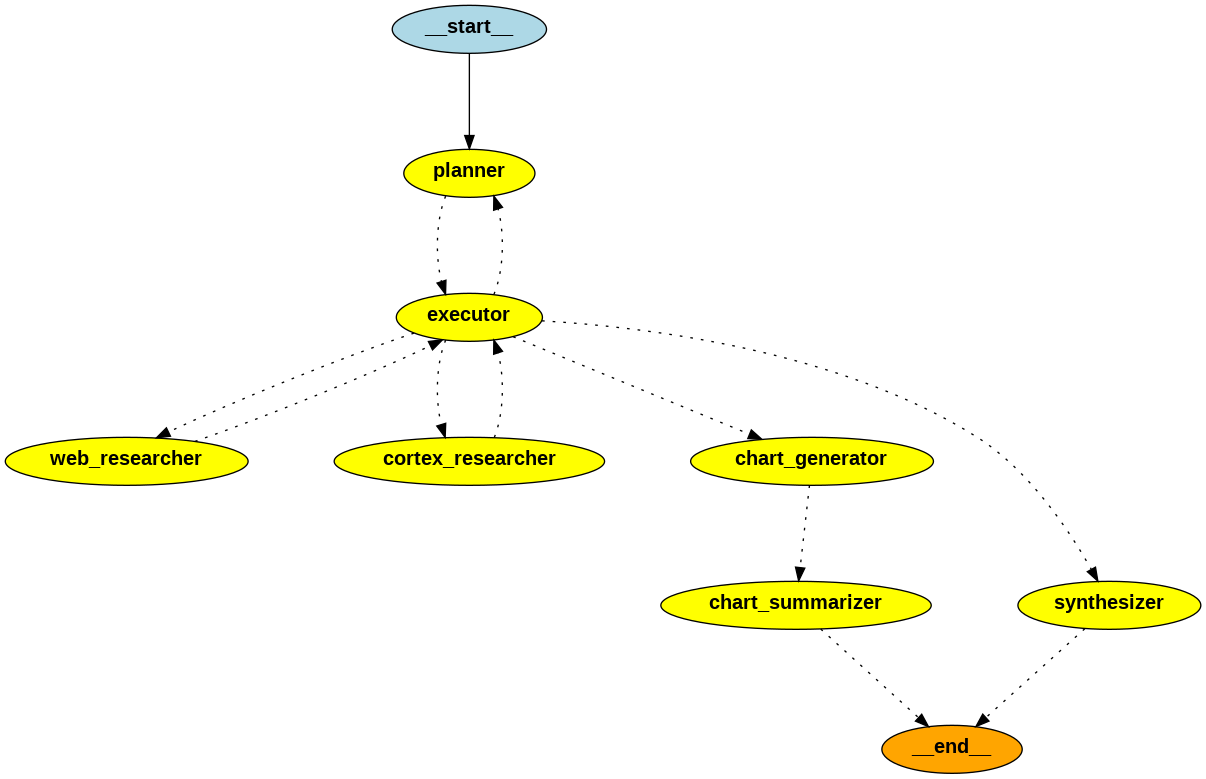

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

## 3.5 Use the agent

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
<p>🚨 &nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results may differ from those shown in the video.

**It's expected for the agent to not answer perfectly**:

- If the first query does not chart any results, or plots a chart showing companies A, B and C, or mentions that it doesn't have access to the required data, that's okay. It might be because the Cortex agent decided to choose the Cortex Search tool (access to meeting notes only) instead of the Cortex Analyst tool (access to client deals data). You do not need to re-run the queries.
- The same applies to the second and third queries. If the agent does not return a perfect answer, that's okay. You do not need to re-run it.
</div>

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> The following three queries might take <b>2-5 minutes</b> to output the results.</p>

Query: What are our top 3 customer deals? Chart the deal value for each.


Python REPL can execute arbitrary code. Use with caution.


Chart summarizer answer: Let's save the file to a valid temporary directory typically used for saving files in this environment. I will correct the code to use such a directory.
--------------------------------


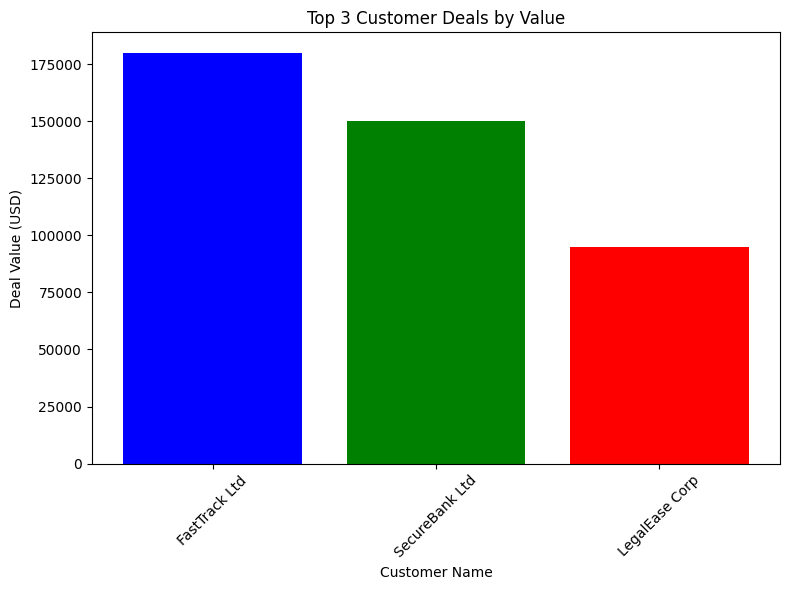

In [16]:
from langchain.schema import HumanMessage

query = "What are our top 3 customer deals? Chart the deal value for each."
print(f"Query: {query}")
state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["cortex_researcher", "web_researcher", "chart_generator", "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

In [ ]:
query = "Identify our pending deals, research if they may be experiencing regulatory changes, and using the meeting notes for each customer, provide a new value proposition for each given the regulatory changes."
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["cortex_researcher", "web_researcher", "chart_generator", "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

Query: Identify our pending deals, research if they may be experiencing regulatory changes, and using the meeting notes for each customer, provide a new value proposition for each given the regulatory changes.


In [ ]:
query = "Is there a common theme across our meeting notes?"
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["cortex_researcher", "web_researcher", "chart_generator", "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

To ensure high quality, you need to add observability!

In the next lesson, you'll add tracing and goal completion evaluation to understand your agent's performance.